In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate

wer  = evaluate.load('wer')

from scipy.signal import resample

def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

c:\Users\cyrine.anene_amaris\Documents\whisper_fine_tuned\Fine-tuning-Whisper-Air-Traffic-Control\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='english',task='transcribe')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='english',task='transcribe')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [3]:
atco_asr_data = load_dataset('parquet',data_files="dataset/train-00000-of-00005-c6681348ac8543dc.parquet")

#### Maximum length of transription 

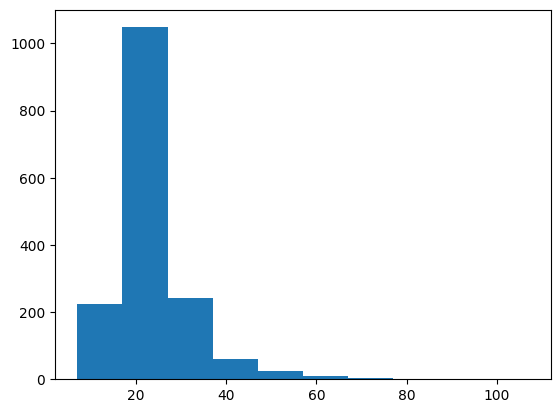

In [4]:
list_of_transcription_lengths = []

for sample in atco_asr_data['train']:
    text = sample['text']
    tokenized_text = tokenizer(text).input_ids
    list_of_transcription_lengths.append(len(tokenized_text))
    # break

plt.hist(list_of_transcription_lengths)
plt.show()

Because of this hist, we chose 60 as our transcription size. If < 60, then it is padded (-100) and if > 60 it is truncated.

#### Converting Dataset to Pytorch compatible format

In [5]:
class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item["text"]

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [6]:
dataset = whisper_training_dataset(dataset=atco_asr_data['train'], max_len=60)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

#### Training Model

In [8]:
def evaluation(model):

    atco_asr_data = load_dataset('parquet',data_files="dataset/validation-00000-of-00002-7a5ea3756991bf72.parquet")

    model.eval()

    predictions=[]
    references=[]

    for sample in tqdm(atco_asr_data['train'],total=len(atco_asr_data['train'])):
        audio=sample['audio']['array']
        sample_rate=sample['audio']['sampling_rate']
        text=sample['text']

        audio = down_sample_audio(audio, sample_rate) # downsample the audio to 16000Hz for WHISPER

        input_features = feature_extractor(
        raw_speech=audio,
        sampling_rate=16000,
        return_tensors='pt',
        padding=True).input_features

        # Generate predictions with no gradient computation
        with torch.no_grad():
            op = model.generate(input_features.to('cuda'), language='english', task='transcribe')

        # Decode predictions
        text_preds = tokenizer.batch_decode(op, skip_special_tokens=True)

        # Append batch predictions and references to the respective lists
        predictions.extend(text_preds)
        references.extend([text])

    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER

In [ ]:
from IPython.display import clear_output

device='cuda'

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)

max_epochs=1

running_wer=[]

for epoch in tqdm(range(max_epochs)):
    print(f"Epoch {epoch}")
    i =0
    for batch in train_dataloader:
        i= i+ 1
        print(f"Bacth {i}")
        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients

    running_wer.append(evaluation(model))
    plt.plot(running_wer)
    clear_output(wait=True)
    plt.xlabel('epochs')
    plt.ylabel('wer (%)')
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
Bacth 1


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Bacth 2
Bacth 3
Bacth 4
Bacth 5
Bacth 6
Bacth 7
Bacth 8
Bacth 9
Bacth 10
Bacth 11
Bacth 12
Bacth 13
Bacth 14
Bacth 15
Bacth 16
Bacth 17
Bacth 18
Bacth 19
Bacth 20
Bacth 21
Bacth 22
Bacth 23
Bacth 24
Bacth 25
Bacth 26
Bacth 27
Bacth 28
Bacth 29
Bacth 30
Bacth 31
Bacth 32
Bacth 33
Bacth 34
Bacth 35
Bacth 36
Bacth 37
Bacth 38
Bacth 39
Bacth 40
Bacth 41
Bacth 42
Bacth 43
Bacth 44
Bacth 45
Bacth 46
Bacth 47
Bacth 48
Bacth 49
Bacth 50
Bacth 51
Bacth 52
Bacth 53
Bacth 54
Bacth 55
Bacth 56
Bacth 57
Bacth 58
Bacth 59
Bacth 60
Bacth 61
Bacth 62
Bacth 63
Bacth 64
Bacth 65
Bacth 66
Bacth 67
Bacth 68
Bacth 69
Bacth 70
Bacth 71
Bacth 72
Bacth 73
Bacth 74
Bacth 75
Bacth 76
Bacth 77
Bacth 78
Bacth 79
Bacth 80
Bacth 81
Bacth 82
Bacth 83
Bacth 84
Bacth 85
Bacth 86
Bacth 87
Bacth 88
Bacth 89
Bacth 90
Bacth 91
Bacth 92
Bacth 93
Bacth 94
Bacth 95
Bacth 96
Bacth 97
Bacth 98
Bacth 99
Bacth 100
Bacth 101
Bacth 102
Bacth 103
Bacth 104
Bacth 105
Bacth 106
Bacth 107
Bacth 108
Bacth 109
Bacth 110
Bacth 111
Bacth 

In [ ]:
model.load_state_dict(torch.load('finetuned_atco.pth', weights_only=True))# loading the model
model.eval()
model.to('cuda')

In [ ]:
model.eval()
atco_asr_data = load_dataset('parquet',data_files="validation-00000-of-00002-7a5ea3756991bf72.parquet")

for idx in range(5):

    target = atco_asr_data['train'][idx]['text']
    audio_original = atco_asr_data['train'][idx]['audio']['array']

    input_feature = feature_extractor(raw_speech=audio_original,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='english', task='transcribe')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')